In [1]:
### Imports (TODO remove this when finished)
%load_ext autoreload

%autoreload 2

# Append root folder in case you haven't installed NIDN
import sys
sys.path.append("../")

import nidn

12:52:40|NIDN-INFO| Initialized NIDN for cpu
12:52:40|NIDN-INFO| Using double precision


# Letting the NIDN learn the permivvivity of Titanium Dioxide

Here, we pass an already calculated spectrum from TiO2, and test if the NIDN returns the permittivity of TiO2. If it does, it succesfully is able to learn the correct permittivity required for a single layer to match the desired spectrum

Physical wavelengths are (in meters):
[1.00000000e-06 8.25000000e-07 7.02127660e-07 6.11111111e-07
 5.40983607e-07 4.85294118e-07 4.40000000e-07 4.02439024e-07
 3.70786517e-07 3.43750000e-07 3.20388350e-07 3.00000000e-07]


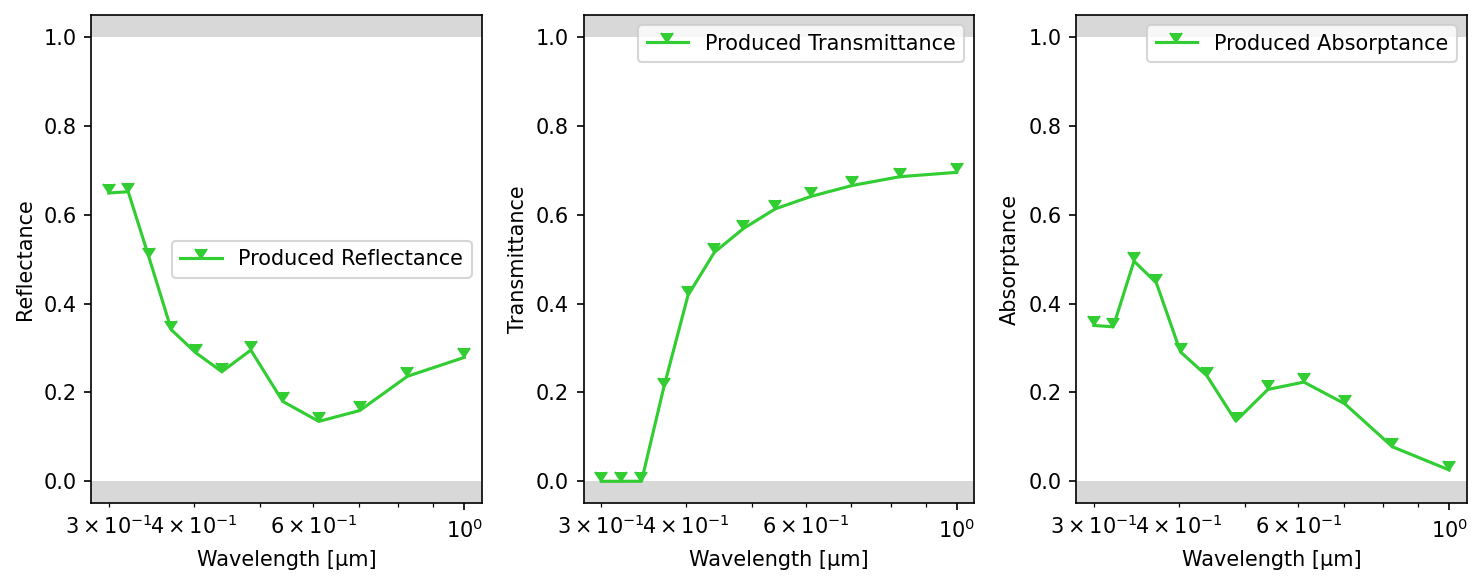

In [2]:
# Load default cfg as starting point

cfg = nidn.load_default_cfg()

# Specify your desired range of wavelengths

cfg.physical_wavelength_range[0] = 3e-7
cfg.physical_wavelength_range[1] = 1e-6

# Let's investigate 32 frequency points
cfg.N_freq = 12

# Currently, the target spectra is set manually as a list of numbers 
cfg.target_reflectance_spectrum = [0.27891510,0.23644109,0.15938656,0.13485510,0.17970238,0.29539180,0.24678705,0.28984702,0.34120250,0.50414005,0.65206676,0.64914470]
cfg.target_transmittance_spectrum = [0.69567667,0.68589939,0.66614408,0.64175525,0.61354260,0.56891946,0.51561534,0.41896730,0.21201846,0.00011344,0.00000001,0.00000000]
# Since R + T + A = 1, we only need to give the reflectance and transmittance (absorptance is implicit)

nidn.plot_spectrum(cfg,
                   cfg.target_reflectance_spectrum,
                   cfg.target_transmittance_spectrum)

physical_wls, normalized_freqs = nidn.get_frequency_points(cfg)
print("Physical wavelengths are (in meters):")
print(physical_wls)

## Example 1 - Uniform single-layer with unrestricted epsilon

Let's start with a uniform single-layer and see if NIDN can get sufficiently close to the ground truth.

In [3]:
cfg.Nx = 1 # Set layer size  to 1x1 (interpreted as uniform)
cfg.Ny = 1
cfg.N_layers = 1 # Choose number of layers

# Allowed range of epsilon values
cfg.real_min_eps = 0.0
cfg.real_max_eps = 20.0
cfg.imag_min_eps = 0.0
cfg.imag_max_eps = 3.0

cfg.type = "regression" # Choose type as described above
cfg.iterations = 100 # Set number of training iterations (that is forward model evaluations) to perform

cfg.FDTD_niter = 400
cfg.solver = "FDTD"

In [4]:
#Show all used settings
nidn.print_cfg(cfg)
nidn.set_log_level("DEBUG")

name                   : example_name   |use_gpu                : 0              |seed                   : 100            |
model_type             : siren          |iterations             : 100            |learning_rate          : 8e-05          |
type                   : regression     |reg_loss_weight        : 0.05           |use_regularization_loss: 1              |
L                      : 1.0            |absorption_loss        : 0              |n_neurons              : 100            |
hidden_layers          : 9              |encoding_dim           : 4              |siren_omega            : 1.0            |
add_noise              : 0              |noise_scale            : 0.001          |eps_oversampling       : 1              |
real_min_eps           : 0.0            |real_max_eps           : 20.0           |imag_min_eps           : 0.0            |
imag_max_eps           : 3.0            |solver                 : FDTD           |Nx                     : 1              |
Ny      

`print_cfg(cfg)` shows you more or less everything you want to know about the config.
Using `run_training(cfg)`, we run the network until it reaches the number of iterations set above (or until you interrupt it).

In [5]:
nidn.run_training(cfg);

C:\Users\to-bo\.conda\envs\nidn\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


KeyboardInterrupt: 

### Interpretation of results

#### Loss plot

The loss as a function of model evaluations is presented below. As the training evolves, the three losses here, [L1](https://afteracademy.com/blog/what-are-l1-and-l2-loss-functions), Loss, and Weighted Average Loss, can be seen to decrease. {Pablo add link/explanation to the other losses}.

In [ ]:
nidn.plot_losses(cfg)

#### Spectrum plots

The produced RTA spectra are plotted together with the target spectra in the figure below.

In [ ]:
nidn.plot_spectra(cfg)

#### Absolute grid values plot

The complex absolute value of the epsilon over all frequencies is presented here. This plot is in general more useful for patterned multilayers.

In [ ]:
nidn.plot_model_grid(cfg)

#### Epsilon vs frequency and real materials

The following function plots the epsilon values vs. frequency of grid points against real materials in our library. This plot is in general more useful for patterned multilayers.

In [ ]:
nidn.plot_eps_per_point(cfg)

## Example 2 - Uniform single-layer with materials classification

Next up is the same example, a uniform single-layer of titanium oxide, but this time we check if NIDN can predict the correct material.

In [ ]:
cfg.pop("model",None); # Forget the old model
cfg.Nx = 1 # Set layer size  to 1x1 (interpreted as uniform)
cfg.Ny = 1
cfg.N_layers = 1 # Choose number of layers

cfg.type = "classification" # Choose type as described above
cfg.iterations = 100 # Set number of training iterations (that is forward model evaluations) to perform

In [ ]:
nidn.run_training(cfg);

In [ ]:
nidn.plot_losses(cfg)
nidn.plot_spectra(cfg)
nidn.plot_model_grid(cfg)
nidn.plot_eps_per_point(cfg)

As can be seen from the plots, the prediction is correct and the loss is even lower.

## Example 3 - Optical filter with regression

The goal of using NIDN is to find a structure with reflection, transmission, and reflection spectra as close to you target spectra as possible. We might for instance want a filter that has a high transmission for wavelengths around 1550 nm and low transmission for other wavelengths. The reflection should be opposite to that of the transmission and the absorption should be minimal for all wavelengths.
The target spectra with these requirements can be set using the following code:

For the third and final example, we will try to find a structure that satisfies these requirements setting the target spectra using regression. The structure would work as an optical filter with transmission only for wavelengths around 1550 nm.
The structure consists of Y layers with X x X grid points per layer. As can be seen in the code below, we make use of oversampling.

In [ ]:
# Define target for the filter
cfg = nidn.load_default_cfg()
cfg.N_freq = 20
cfg.target_reflectance_spectrum =   12*[1.0] + [0.0] + 7*[1.0]
cfg.target_transmittance_spectrum = 12*[0.0] + [1.0] + 7*[0.0]
cfg.physical_wavelength_range[0] = 1e-6
cfg.physical_wavelength_range[1] = 1e-5
cfg.freq_distribution = "linear"


nidn.plot_spectrum(cfg,
                   cfg.target_reflectance_spectrum,
                   cfg.target_transmittance_spectrum)

In [ ]:
# Allowed range of epsilon values
cfg.real_min_eps = 0.0
cfg.real_max_eps = 20.0
imag_min_eps = 0.0
imag_max_eps = 3.0

cfg.Nx = 1 # Set layer size  to 16x16 (each of the grid points has its own epsilon now)
cfg.Ny = 1
cfg.eps_oversampling = 1
cfg.N_layers = 10 # Less layer to keep compute managable
cfg.type = "regression" # Choose type as described above (for now still regression)
cfg.iterations = 3000 # Set number of training iterations (that is forward model evaluations) to perform

In [ ]:
nidn.run_training(cfg);

In [ ]:
# The other plots
nidn.plot_losses(cfg)
nidn.plot_spectra(cfg)
nidn.plot_model_grid(cfg)
nidn.plot_eps_per_point(cfg)

NIDN is able to get quite close to the desired spectra with the unrestricted epsilon. 

#### Material ID plot

Finally, we will present another plot, showing the real materials closest to the unrestricted ones for each grid point.
The layers are numbered from bottom to top, and the light is incident on the first layer, i.e., the bottom of the stack.

In [ ]:
nidn.plot_material_grid(cfg)

NB Here we should have plotted the RTA result of this structure.
In case you want to save results you can use this handy function to save it to the results folder with a current timestamp.

In [ ]:
nidn.save_run(cfg)

# You can save all available plots to a single folder using this function
nidn.save_all_plots(cfg,save_path="/results/example/")

In [ ]:
# Squared german & tantalum layer
cfg = nidn.load_default_cfg()
cfg.N_freq = 20
cfg.target_reflectance_spectrum =   [0.60248210,0.20808528,0.10825184,0.55990793,0.72659247,0.74876763,0.65817925,0.32626005,0.03080333,0.50414092,0.71607931,0.75605811,0.68509433,0.38961000,0.01012443,0.48532436,0.71720245,0.76067772,0.69521557,0.41321222,]
cfg.target_transmittance_spectrum = [0.38656270,0.77990755,0.88060908,0.43550853,0.27110902,0.24957937,0.33986960,0.67012270,0.96391071,0.49316468,0.28246341,0.24277933,0.31350818,0.60775718,0.98545664,0.51235020,0.28152825,0.23829265,0.30353337,0.58443205,]
cfg.physical_wavelength_range[0] = 2e-6
cfg.physical_wavelength_range[1] = 1e-5
cfg.freq_distribution = "linear"

nidn.plot_spectrum(cfg,
                   cfg.target_reflectance_spectrum,
                   cfg.target_transmittance_spectrum)

In [ ]:
cfg.pop("model",None); # Forget the old model
cfg.Nx = 9 # Set layer size  to 1x1 (interpreted as uniform)
cfg.Ny = 9
cfg.eps_oversampling = 3
cfg.N_layers = 1 # Choose number of layers
cfg.type = "regression" # Choose type as described above
cfg.iterations = 5000 # Set number of training iterations (that is forward model evaluations) to perform

In [ ]:
nidn.run_training(cfg);

In [ ]:
nidn.plot_losses(cfg)
nidn.plot_spectra(cfg)
nidn.plot_model_grid(cfg)
nidn.plot_eps_per_point(cfg)

In [ ]:
cfg.pop("model",None); # Forget the old model
cfg.Nx = 9 # Set layer size  to 1x1 (interpreted as uniform)
cfg.Ny = 9
cfg.eps_oversampling = 3
cfg.N_layers = 1 # Choose number of layers
cfg.type = "classification" # Choose type as described above
cfg.iterations = 5000 # Set number of training iterations (that is forward model evaluations) to perform

In [ ]:
nidn.run_training(cfg);

In [ ]:
nidn.plot_losses(cfg)
nidn.plot_spectra(cfg)
nidn.plot_model_grid(cfg)
nidn.plot_eps_per_point(cfg)